The goal of this notebook is to organize the process of doing a regression analysis. The steps I see for the process are the following:  
1) Data exploration and preparation  
2) Choosing the model type(s) to test  
3) Testing the model    

I'm going to test this with the 2015 NYC Citibike data for NYC. I will try to predict the number of daily users with the info in the Citibike data and historical weather data from wunderground.com.

## Part I: Data Exploration and Preparation

In [5]:
#Import some of the tools I know I will need:
import numpy as np
import pandas as pd
import requests
import zipfile
import io
from datetime import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

# Python 2 & 3 Compatibility
from __future__ import print_function, division

%matplotlib inline

Make a list of all the files for the year 2015:

In [3]:
file_num = ["%.2d" % (i+1) for i in range(12)]


Open them as pandas dataframes and append them to a list:

In [162]:
data_2015 = []
for number in file_num:
    zip_file = 'https://s3.amazonaws.com/tripdata/2015'+ number + '-citibike-tripdata.zip'
    print(zip_file)
    r = requests.get(zip_file)
    with zipfile.ZipFile(io.BytesIO(r.content)) as ar:
        csv_file = '2015' + number + '-citibike-tripdata.csv'
        data_2015.append(pd.read_csv(ar.open(csv_file)))

https://s3.amazonaws.com/tripdata/201501-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201502-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201503-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201504-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201505-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201506-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201507-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201508-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201509-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201510-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201511-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201512-citibike-tripdata.zip


Check which months have a different datetime format:

In [165]:
i=1
for df in data_2015:
    print( "month =", i)
    print( "starttime", df['starttime'][1])
    print( "stoptime", df['stoptime'][1])
    print ("shape", df.shape)
    i=i+1

month = 1
starttime 1/1/2015 0:02
stoptime 1/1/2015 0:08
shape (285552, 15)
month = 2
starttime 2/1/2015 0:00
stoptime 2/1/2015 0:07
shape (196930, 15)
month = 3
starttime 3/1/2015 0:01
stoptime 3/1/2015 0:14
shape (341826, 15)
month = 4
starttime 4/1/2015 00:00:52
stoptime 4/1/2015 00:10:31
shape (652390, 15)
month = 5
starttime 5/1/2015 00:00:28
stoptime 5/1/2015 00:25:52
shape (961986, 15)
month = 6
starttime 6/1/2015 0:00
stoptime 6/1/2015 0:05
shape (941219, 15)
month = 7
starttime 7/1/2015 00:00:06
stoptime 7/1/2015 00:05:29
shape (1085676, 15)
month = 8
starttime 8/1/2015 00:00:05
stoptime 8/1/2015 00:05:06
shape (1179044, 15)
month = 9
starttime 9/1/2015 00:00:00
stoptime 9/1/2015 00:02:45
shape (1289699, 15)
month = 10
starttime 10/1/2015 00:00:02
stoptime 10/1/2015 00:09:55
shape (1212277, 15)
month = 11
starttime 11/1/2015 00:00:01
stoptime 11/1/2015 00:18:15
shape (987245, 15)
month = 12
starttime 12/1/2015 07:38:15
stoptime 12/1/2015 07:49:39
shape (804125, 15)


Months 4,5,7,8,9,10,11,12 have a different date time format. Will need to convert all to datetime format seperately.

In [167]:
month = 0
for df in data_2015:
    month = month+1
    other_format = [4,5,7,8,9,10,11,12]
    if month in other_format:
        print(month)
        df['starttime'] = pd.to_datetime(df['starttime'], format = '%m/%d/%Y %H:%M:%S')
        df['stoptime'] = pd.to_datetime(df['stoptime'], format = '%m/%d/%Y %H:%M:%S')
    else:
        print(month)
        df['starttime'] = pd.to_datetime(df['starttime'], format = '%m/%d/%Y %H:%M')
        df['stoptime'] = pd.to_datetime(df['stoptime'], format = '%m/%d/%Y %H:%M')

1
2
3
4
5
6
7
8
9
10
11
12


Combine dataframes into one dataframe

In [168]:
trip_data = pd.concat(data_2015)

Pickle the dataframe so I dont have to load it again:

In [169]:
trip_data.to_pickle("raw_citibike_data.pkl")

Read in pickled df if needed:

In [7]:
trip_data = pd.read_pickle("/Users/torrie/Documents/Metis_Take_Home/raw_citibike_data.pkl")

In [8]:
trip_data = trip_data.reset_index()
trip_data = trip_data.drop('index', axis = 1)

In [9]:
trip_data.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,2015-01-01 00:01:00,2015-01-01 00:24:00,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,2015-01-01 00:02:00,2015-01-01 00:08:00,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1


In [10]:
print("There are",trip_data.shape[0],"trips logged in this dataset")

There are 9937969 trips logged in this dataset


Check for nulls:

In [11]:
trip_data.isnull().sum()

tripduration                     0
starttime                        0
stoptime                         0
start station id                 0
start station name               0
start station latitude           0
start station longitude          0
end station id                   0
end station name                 0
end station latitude             0
end station longitude            0
bikeid                           0
usertype                         0
birth year                 1311378
gender                           0
dtype: int64

Looks like only birth_year is missing data.

Check data types:

In [12]:
trip_data.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
gender                              int64
dtype: object

In [13]:
trip_data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,9.937969e+06,9.937969e+06,9.937969e+06,9.937969e+06,9.937969e+06,9.937969e+06,9.937969e+06,9.937969e+06,8.626591e+06,9.937969e+06
mean,9.680877e+02,6.181264e+02,4.073592e+01,-7.398947e+01,6.105992e+02,4.073563e+01,-7.398963e+01,1.945289e+04,1.976553e+03,1.068916e+00
std,7.609485e+03,7.347459e+02,2.042297e-02,1.398510e-02,7.241606e+02,2.037340e-02,1.398808e-02,2.859060e+03,1.156820e+01,5.746586e-01
min,6.000000e+01,7.200000e+01,4.064677e+01,-7.401713e+01,7.200000e+01,4.064677e+01,-7.405044e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,3.890000e+02,3.140000e+02,4.072182e+01,-7.399932e+01,3.120000e+02,4.072165e+01,-7.399973e+01,1.698300e+04,1.969000e+03,1.000000e+00
50%,6.290000e+02,4.320000e+02,4.073705e+01,-7.399021e+01,4.280000e+02,4.073653e+01,-7.399054e+01,1.938700e+04,1.979000e+03,1.000000e+00
75%,1.049000e+03,5.020000e+02,4.075098e+01,-7.398135e+01,4.990000e+02,4.075097e+01,-7.398142e+01,2.210000e+04,1.986000e+03,1.000000e+00
max,5.864661e+06,3.242000e+03,4.078721e+01,-7.392989e+01,3.242000e+03,4.078721e+01,-7.392989e+01,2.476900e+04,1.999000e+03,2.000000e+00


Make a copy and drop items relating to specific trips rather than the day as a whole, i.e., any information that could not be known ahead of time and used to predict.


In [14]:
trip_data_model = trip_data.copy()
trip_data_model = trip_data_model.drop([u'tripduration', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'], axis = 1)
trip_data_model.columns

Index([u'starttime'], dtype='object')

In [15]:
#Add the day and the month as columns so they can be used as predictors
trip_data_model['day_of_week'] = trip_data_model['starttime'].dt.dayofweek
trip_data_model['month'] = trip_data_model['starttime'].dt.month
trip_data_model['date'] = trip_data_model['starttime'].dt.date

In [16]:
trip_data_model['Day_total'] = trip_data_model['month'].groupby(trip_data_model['date']).transform('count')

In [17]:
trip_data_model_f1 = trip_data_model.groupby(['date','month','day_of_week']).count().drop('starttime', axis = 1).reset_index()

In [18]:
weather_df= pd.read_excel('/Users/torrie/Documents/Metis_Take_Home/NY_weather.xlsx', skiprows=None) 

In [19]:
weather_df = weather_df.rename(columns = {'high hind':'wind max', 'Unnamed: 8':'Events', 'sum':'Precip(in)', 'Date':'date'})

In [20]:
weather_df = weather_df[weather_df['Day'] != 2015]
date_range = range(32)
weather_df = weather_df[weather_df['Day'].isin(date_range)]
weather_df = weather_df.drop(['wind max','gusts','Events','high Temp', 'temp low','Events'], axis = 1)
weather_df.head()

,Day,temp avg,avg wind,Precip(in),date
0,1,34,17,0,2015-01-01
1,2,40,14,0,2015-01-02
2,3,39,9,0.94,2015-01-03
3,4,49,10,0.47,2015-01-04
4,5,37,20,0,2015-01-05


In [21]:
weather_df['date'] = pd.to_datetime(weather_df["date"], infer_datetime_format=False)

In [22]:
weather_df['Precip(in)'] = weather_df['Precip(in)'].replace('T',0.01)

In [23]:
trip_data_model_f1['date'] = pd.to_datetime(trip_data_model_f1['date'])

In [51]:
all_data = pd.merge(weather_df, trip_data_model_f1, on = 'date')

In [52]:
all_data = all_data.drop(['date','Day'], axis = 1)
all_data.head()

,temp avg,avg wind,Precip(in),month,day_of_week,Day_total
0,34,17,0.00,1,3,5317
1,40,14,0.00,1,4,11304
2,39,9,0.94,1,5,4478
3,49,10,0.47,1,6,7849
4,37,20,0.00,1,0,14506


In [53]:
print(all_data.describe())

         temp avg    avg wind  Precip(in)       month  day_of_week  \
count  365.000000  365.000000  365.000000  365.000000        365.0   
mean    56.389041   10.920548    0.105753    6.526027          3.0   
std     18.268657    4.060902    0.296736    3.452584          2.0   
min     12.000000    2.000000    0.000000    1.000000          0.0   
25%     43.000000    8.000000    0.000000    4.000000          1.0   
50%     58.000000   10.000000    0.000000    7.000000          3.0   
75%     73.000000   13.000000    0.020000   10.000000          5.0   
max     87.000000   28.000000    2.480000   12.000000          6.0   

          Day_total  
count    365.000000  
mean   27227.312329  
std    13470.980912  
min     1107.000000  
25%    15234.000000  
50%    30295.000000  
75%    38285.000000  
max    52706.000000  


### 1) Check for multicolinearity  
If a high degree of multicollinearity exists, either  
a) Use a method that handles collinearity  
b) Remove collinear features  
c) Transform features

In [54]:
#Print the pearson's correlation coefficient for each of the features

print(all_data.corr())

             temp avg  avg wind  Precip(in)     month  day_of_week  Day_total
temp avg     1.000000 -0.332309   -0.017381  0.494853    -0.017068   0.785300
avg wind    -0.332309  1.000000    0.032549 -0.268393    -0.019957  -0.345205
Precip(in)  -0.017381  0.032549    1.000000 -0.012777    -0.014767  -0.244702
month        0.494853 -0.268393   -0.012777  1.000000    -0.009549   0.660832
day_of_week -0.017068 -0.019957   -0.014767 -0.009549     1.000000  -0.172432
Day_total    0.785300 -0.345205   -0.244702  0.660832    -0.172432   1.000000


In [55]:
print(all_data.cov())

                  temp avg      avg wind  Precip(in)         month  \
temp avg        333.743836    -24.653071   -0.094222     31.212374   
avg wind        -24.653071     16.490923    0.039222     -3.763036   
Precip(in)       -0.094222      0.039222    0.088052     -0.013090   
month            31.212374     -3.763036   -0.013090     11.920337   
day_of_week      -0.623626     -0.162088   -0.008764     -0.065934   
Day_total    193259.856179 -18884.222369 -978.150346  30735.098991   

             day_of_week     Day_total  
temp avg       -0.623626  1.932599e+05  
avg wind       -0.162088 -1.888422e+04  
Precip(in)     -0.008764 -9.781503e+02  
month          -0.065934  3.073510e+04  
day_of_week     4.000000 -4.645662e+03  
Day_total   -4645.662088  1.814673e+08  


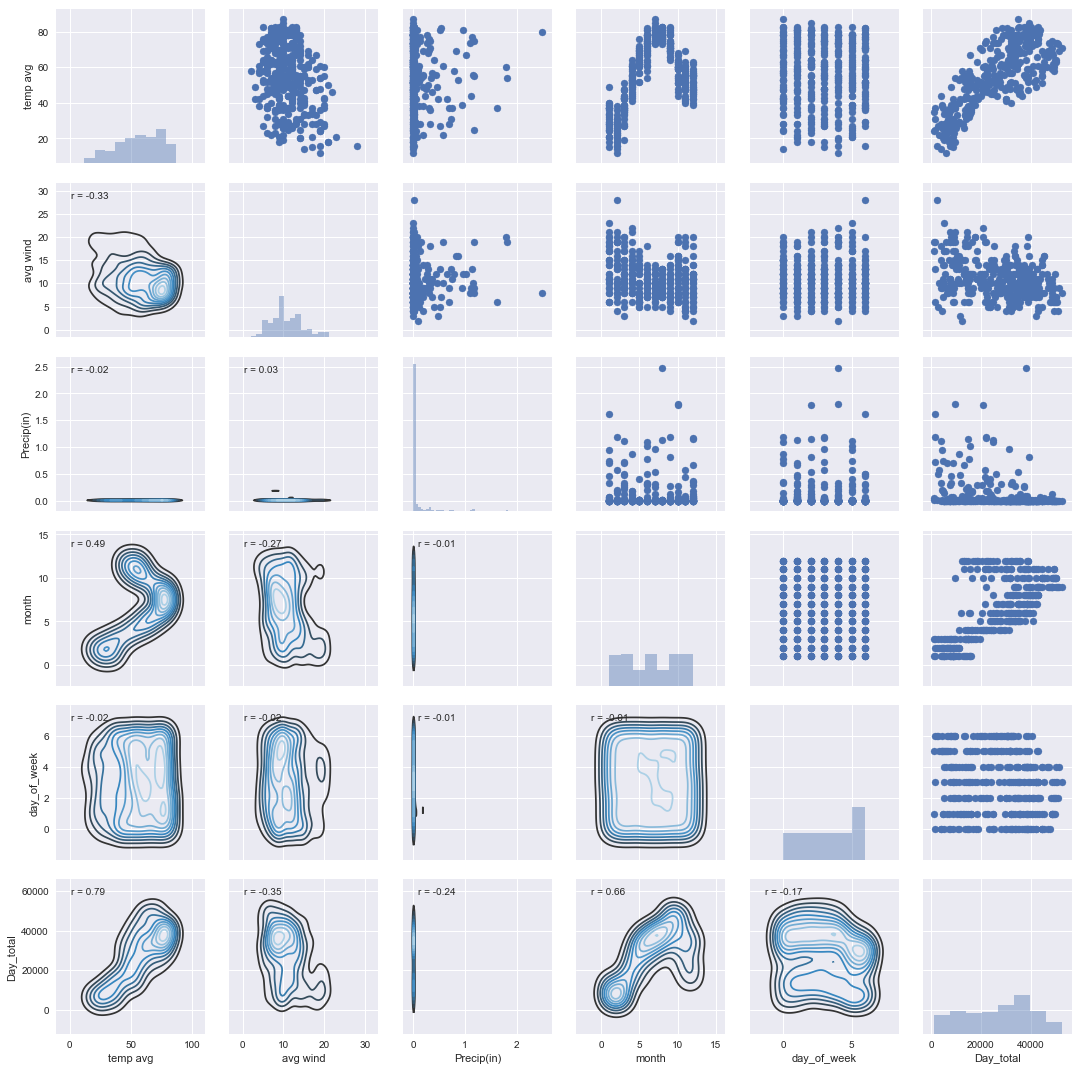

In [29]:
# Make a pairplot with scatterplots, histograms, and a density plot for each variables. 
# This helps us see what the data distribution is like and what our distributions look like
# Correlation coefficients are also printed on each plot
# The info can be used to determine if features need to be transformed and to identify collinear features

from scipy import stats
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(all_data)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.distplot, kde=False)
g.map_lower(corrfunc);

The month and the average temperature look to be correlated, so I will test with both variables and with only average temperature.

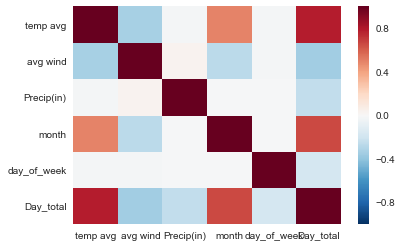

In [30]:
sns.heatmap(all_data.corr());


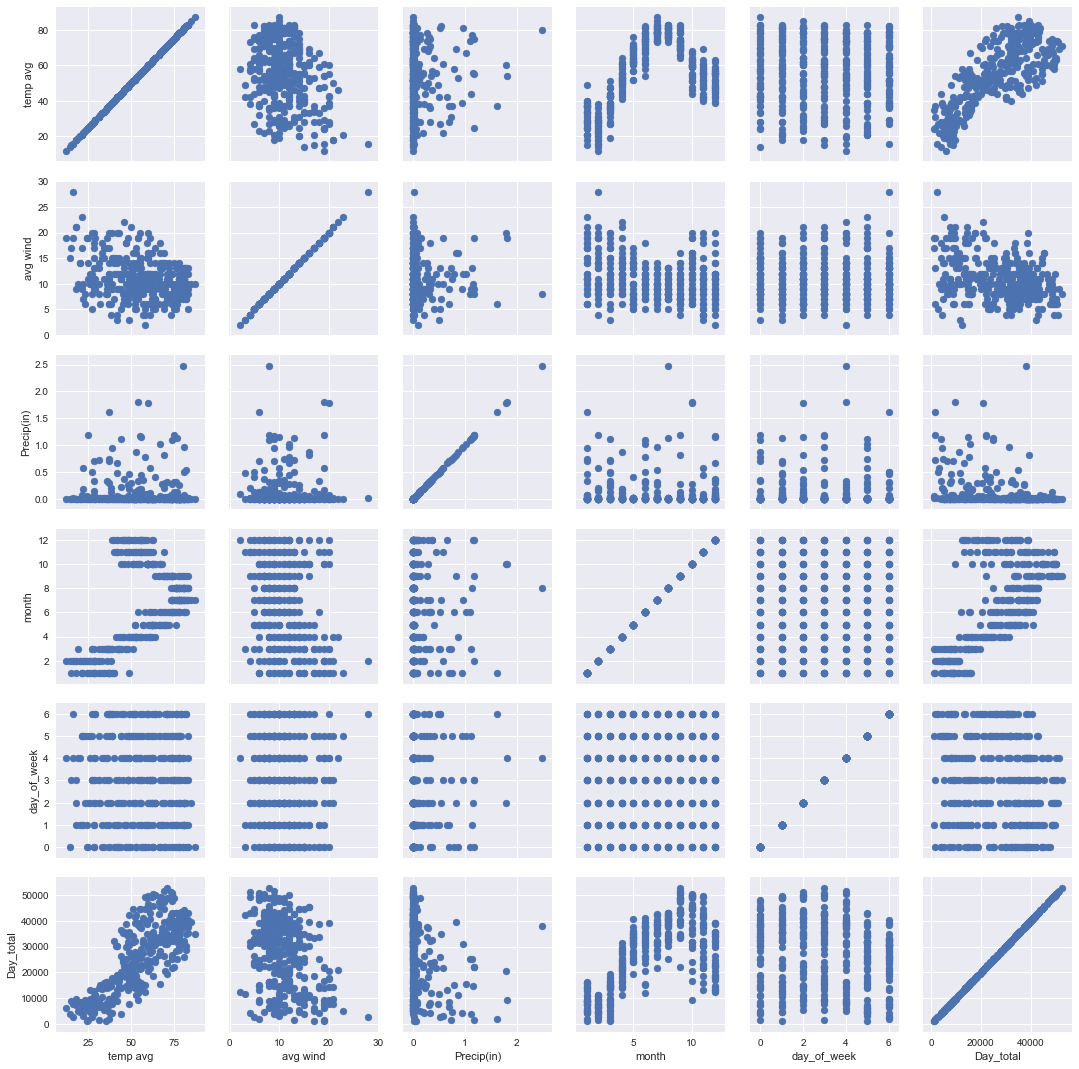

In [31]:
g = sns.PairGrid(all_data)
g.map(plt.scatter);

From the heatmap it is clear that the average temperature and the total daily riders are strongly correlated. 

This checks the variance inflation factor (VIF) of each feature. The VIF is: (fill this in when you figure that out!)

(Code was taken from here: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python)

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh):
    variables = range(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            print('VIF =', vif)
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[variables]


calculate_vif_(all_data, 10.0)

dropping 'temp avg' at index: 0
VIF = [26.999961415189752, 4.3203544585524778, 1.4190537986656375, 8.7767722596917856, 3.3793559421919275, 24.998539841863892]
Remaining variables:
Index([u'avg wind', u'Precip(in)', u'month', u'day_of_week', u'Day_total'], dtype='object')


,avg wind,Precip(in),month,day_of_week,Day_total
0,17,0.00,1,3,5317
1,14,0.00,1,4,11304
2,9,0.94,1,5,4478
3,10,0.47,1,6,7849
4,20,0.00,1,0,14506
5,9,0.07,1,1,8739
6,21,0.00,1,2,9646
7,17,0.00,1,3,8779
8,20,0.07,1,4,7930
9,17,0.00,1,5,6109


### 2) Check the distribution of the target variable(s)    

Transform if necessary



Use Seaborn to make a histogram of the number of trips/day. 

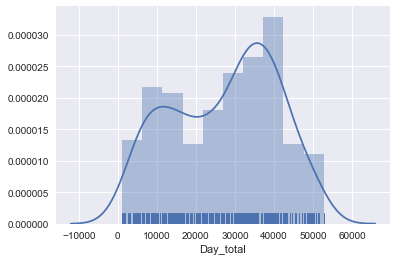

In [134]:
# This is the kde and histogram
sns.distplot(all_data.Day_total, bins = 10, rug=True);

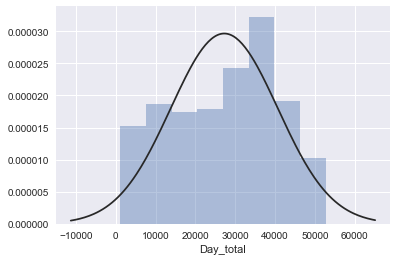

In [108]:
# This is the histogram with a normal distribution plotted. Clearly, the distribution is not normal.
sns.distplot(all_data.Day_total, kde=False, fit=stats.norm);

The distribution looks somewhat bimodal and definitely not normal. We can check a qq plot to see how poorly it fits wiat a normal distribution:

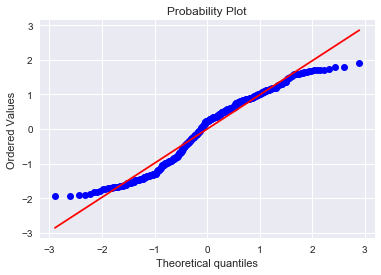

In [84]:
import numpy as np 
import pylab 
import scipy.stats as stats

obs = all_data.Day_total
z = (obs-np.mean(obs))/np.std(obs)

stats.probplot(z, dist="norm", plot=pylab)
pylab.show()


We have a better fit with the uniform data diatribution, but still not great:

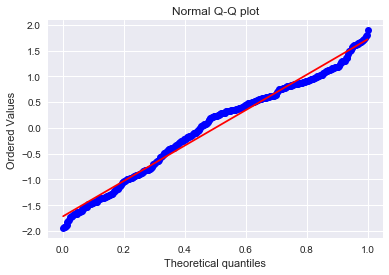

In [83]:
obs = all_data.Day_total
z = (obs-np.mean(obs))/np.std(obs)

stats.probplot(z, dist="uniform", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()
#print(z)

I'd like to figure out what is causing that bimodal distribution. My guess is that week day and weekend traffic have two different peak sizes. Or summer vs winter. I'll add weekend/weekday and the seasons to the data frame to be able to look at where they fall in the distribution. 

In [92]:
all_data['day_type'] = 0
all_data['day_type'][all_data['day_of_week']<5] = 1
all_data['season'] = "summer"
all_data['season'][all_data['month']<5] = 'winter'
all_data['season'][all_data['month']>10] = 'winter'

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


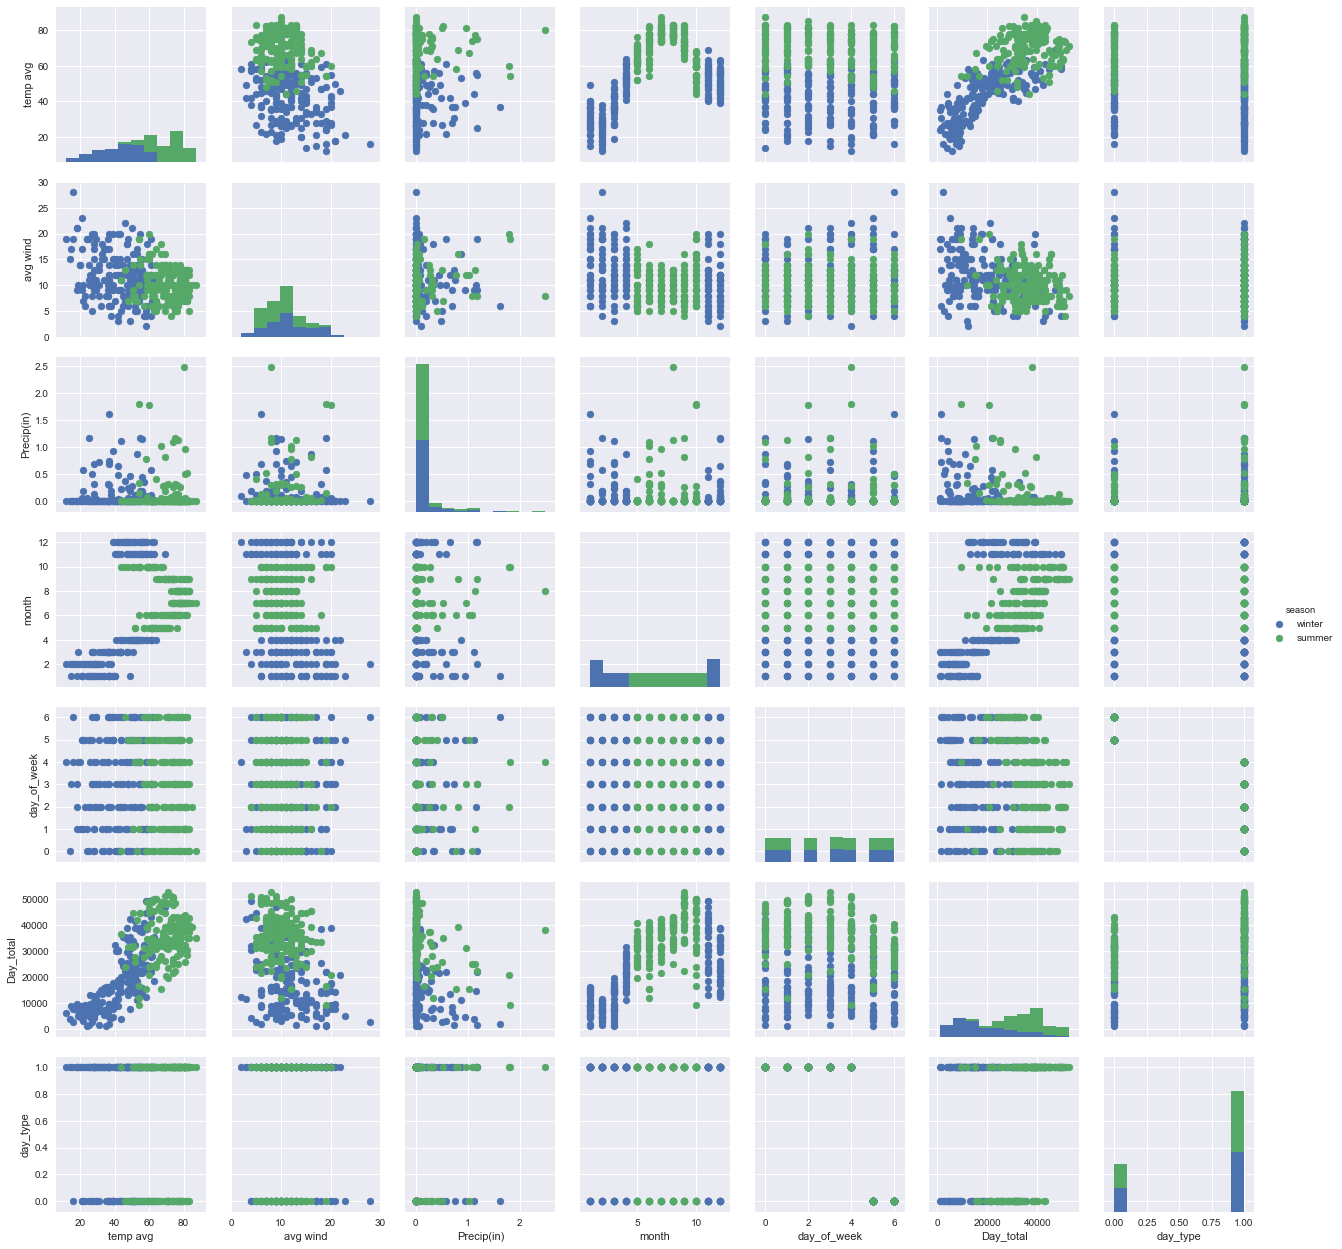

In [93]:
g = sns.PairGrid(all_data, hue="season")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

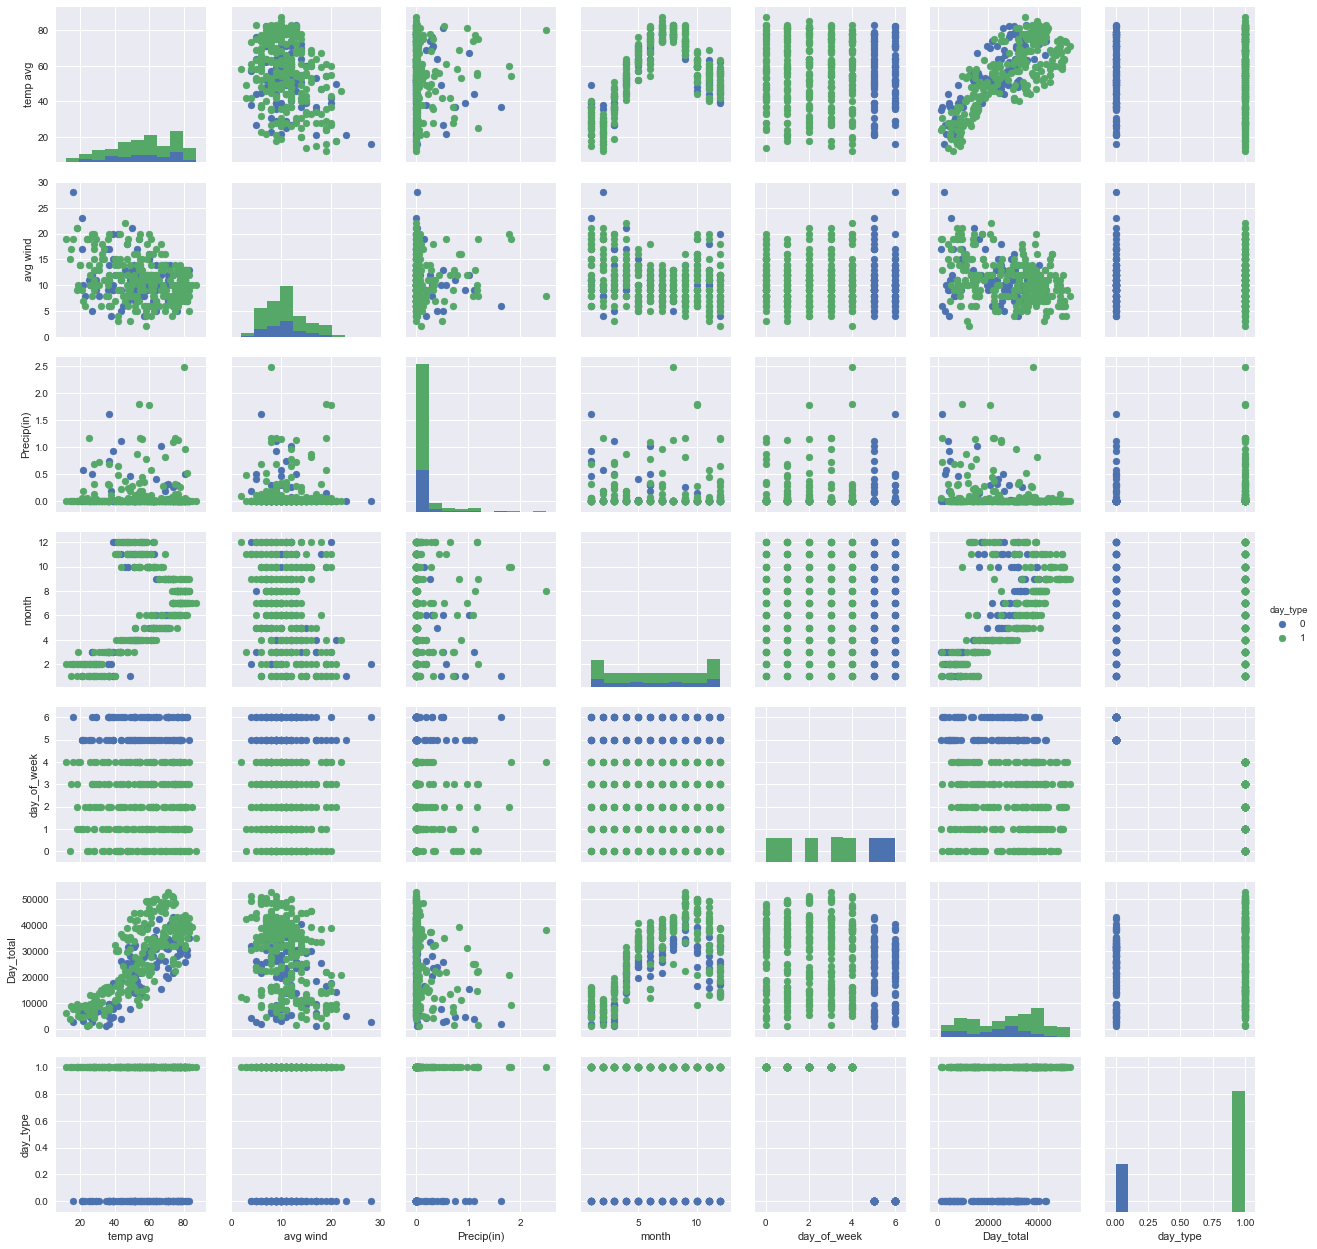

In [89]:
g = sns.PairGrid(all_data, hue="day_type")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

The weekend/weekday theory is clearly not correct. I'll drop that column.
However, the season explanation for the bimodal distribution is interesting. I'll look closer. 

In [96]:
all_data=all_data.drop('day_type', axis =1)

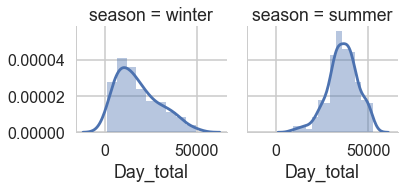

In [306]:
g = sns.FacetGrid(all_data, col="season")
#g.map(plt.hist, "Day_total");
g.map(sns.distplot, "Day_total");

In this case, if we divide the data into two parts based on the season, then we may be able to get a better model for each season becasue the data can be better approximated with a normal/skewed/lognormal distribution. These can be transformed to normal-ish, unlike a bimodal distribution.

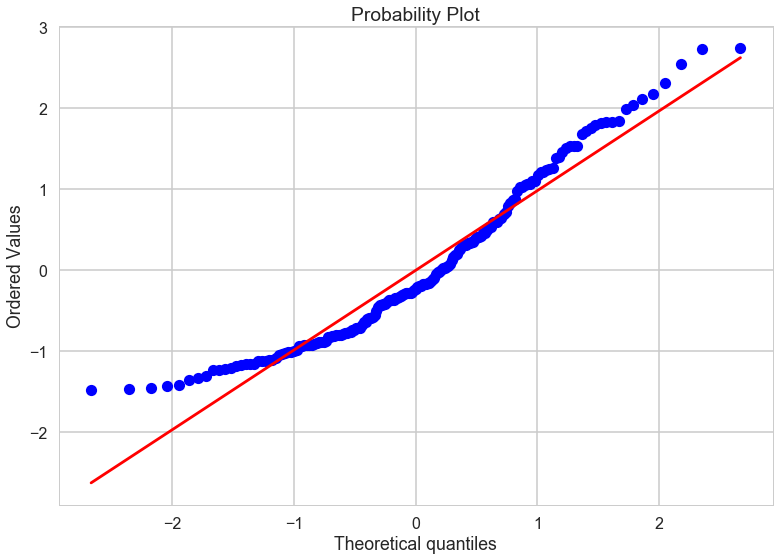

In [305]:
obs = all_data.Day_total[all_data.season == 'winter']
z = (obs-np.mean(obs))/np.std(obs)

stats.probplot(z, dist="norm",plot=pylab)
pylab.show()


In [118]:
all_data['log_Day_total'] = np.log(all_data['Day_total'])

In [122]:
all_data['sqrt_Day_total'] = (all_data['Day_total'])**0.5

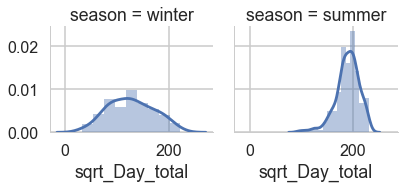

In [302]:
g = sns.FacetGrid(all_data, col="season")
#g.map(plt.hist, "Day_total");
g.map(sns.distplot, "sqrt_Day_total");

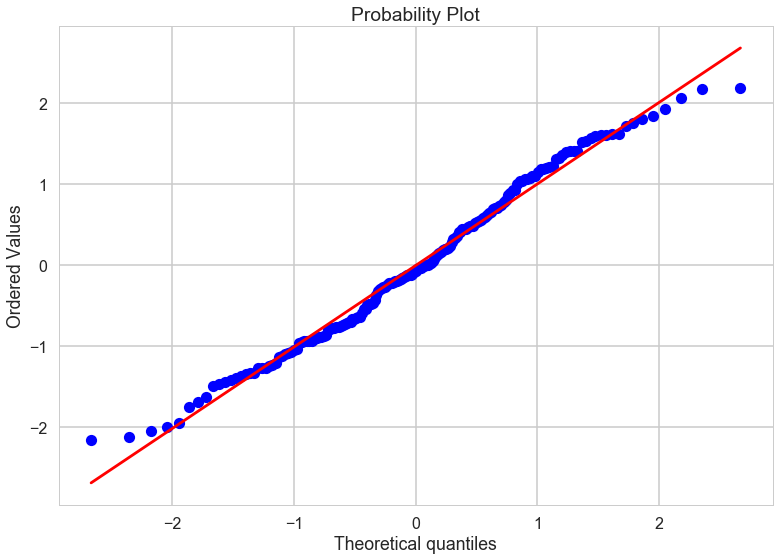

In [303]:
obs = all_data.sqrt_Day_total[all_data.season == 'winter']
z = (obs-np.mean(obs))/np.std(obs)

stats.probplot(z, dist="norm",plot=pylab)
pylab.show()

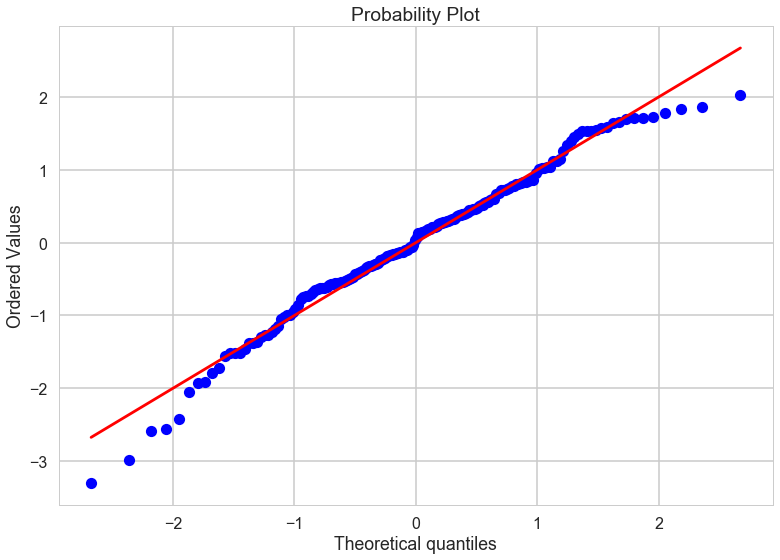

In [304]:
obs = all_data.Day_total[all_data.season == 'summer']
z = (obs-np.mean(obs))/np.std(obs)

stats.probplot(z, dist="norm", plot=pylab)
pylab.show()


In [344]:
# This does not currently work. Why not?

# import numpy as np
# import statsmodels.api as sm
# import pylab

# test = all_data.Day_total[all_data.season == 'summer']

# sm.qqplot(test, line='45')
# pylab.show()


It looks like we could separate the distribution into the two parts, summer and winter. If we transform the winter data with a square root we can get a more normal distribution for that data as well. 

### 3) Remove Outliers

First, just check as scatterplot of the data to see if there are any obvious outliers

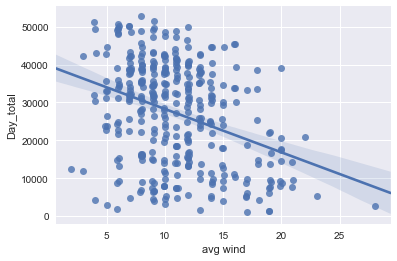

In [137]:
ax = sns.regplot(y=all_data.Day_total, x=all_data['avg wind'], data=all_data, x_jitter=.1)


Nothing is jumping out as a crazy outlier in the above plot.  
Try a boxplot to see if anything shows up in that.

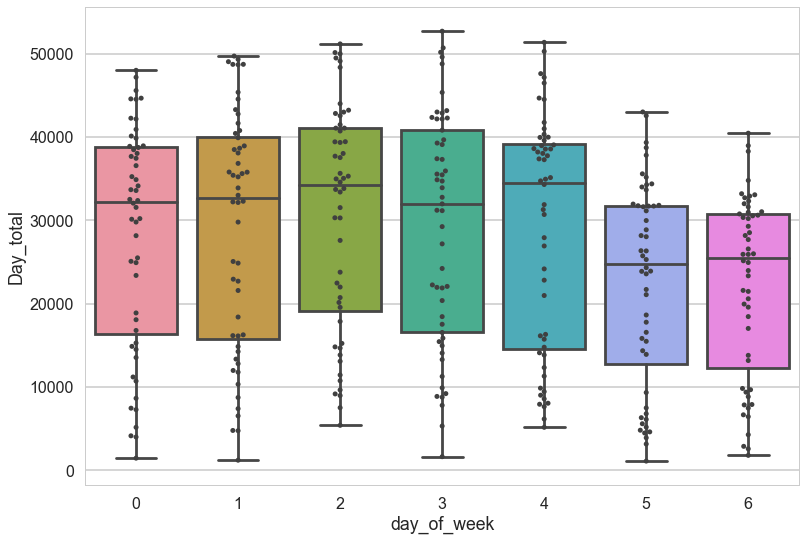

In [307]:
sns.set_context("poster")
sns.set_style("whitegrid")

ax = sns.boxplot(y="Day_total", x="day_of_week", data=all_data)
ax = sns.swarmplot(y="Day_total", x="day_of_week", data=all_data, color=".25")

#sns.despine(offset=10, trim=True);

There are no outliers if we look at the entire dataset together.  

What if we look at the seasons separately:

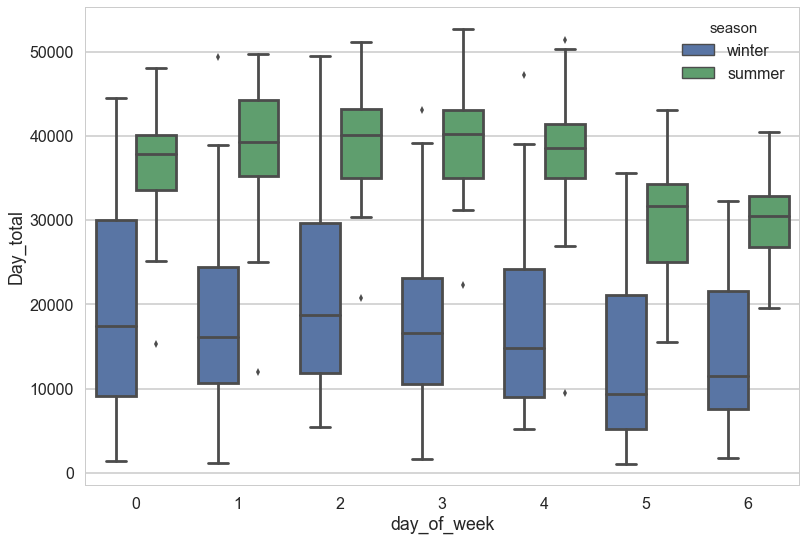

In [148]:
sns.set_context("poster")
sns.set_style("whitegrid")

ax = sns.boxplot(y="Day_total", x="day_of_week", data=all_data, hue = "season")

There are a few outliers here, but lets check and see how many show up in our transformed variables.

Winter Data


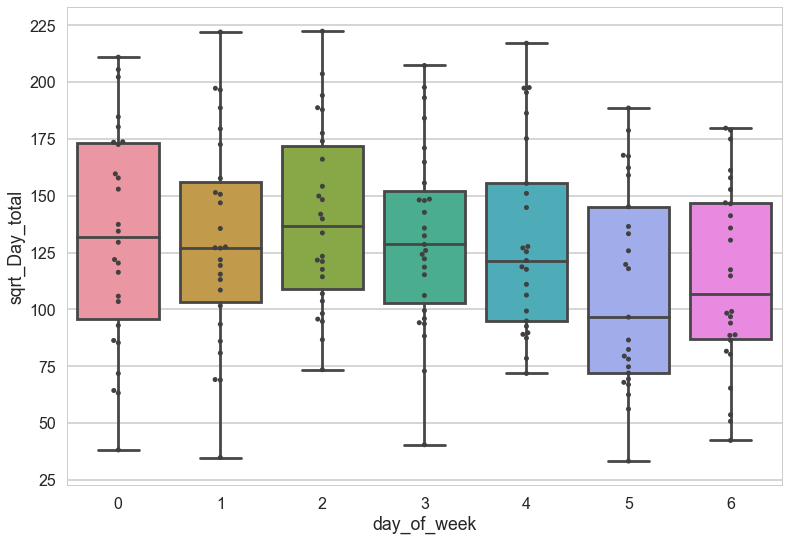

In [293]:
sns.set_context("poster")
sns.set_style("whitegrid")
print("Winter Data")
ax = sns.boxplot(y="sqrt_Day_total", x="day_of_week", data=all_data[all_data['season'] == 'winter'])
ax = sns.swarmplot(y="sqrt_Day_total", x="day_of_week", data=all_data[all_data['season'] == 'winter'],color=".25" )

Summer Data


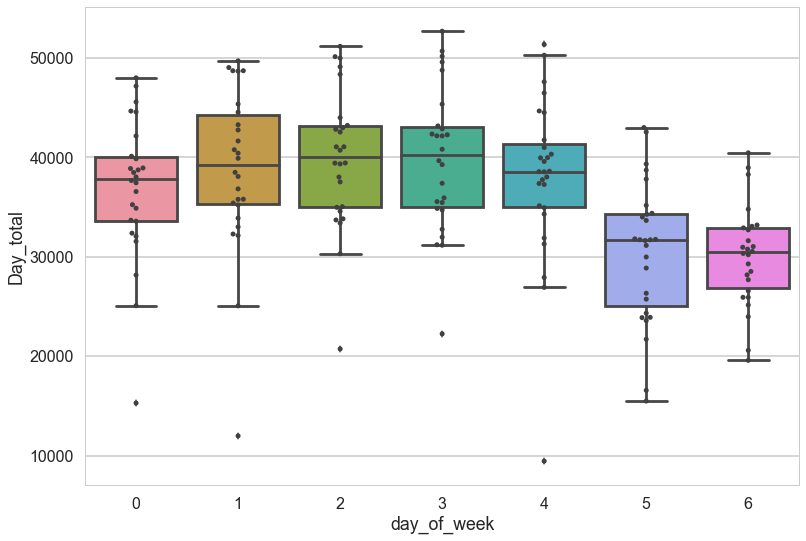

In [294]:
sns.set_context("poster")
sns.set_style("whitegrid")
print("Summer Data")
ax = sns.boxplot(y="Day_total", x="day_of_week", data=all_data[all_data['season'] == 'summer'])
ax = sns.swarmplot(y="Day_total", x="day_of_week", data=all_data[all_data['season'] == 'summer'],color=".25" )

Can also use matplotlib and pandas but its not nearly as pretty:

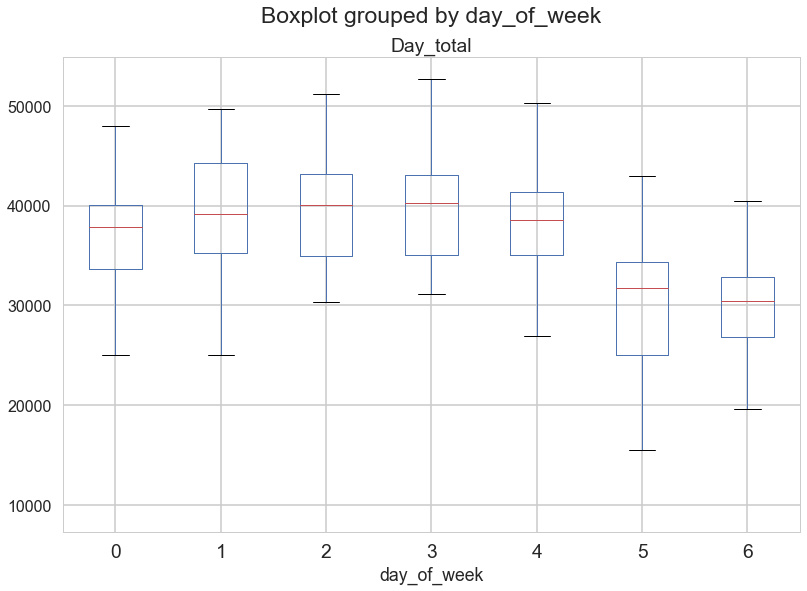

In [230]:
all_data[all_data['season'] == 'summer'].boxplot(column = "Day_total", by='day_of_week')


To find the outliers I need to find the quartile values and calculate the IQR (the distance between 25% and 75%). The Tukey boxplot calls any data point outside the region of 1.5IQR less than the lower quartile (25%) or greater than 1.5IQR greater than the upper quartile (75%) an outlier. The seaborn plot uses these criteria, so that is what I would use it for analysis. 

In [ ]:
all_data_out = all_data.copy()
drop_list = []
for day in range(6):
    IQR = 1.5*(quartiles[day][6] - quartiles[day][4])
    upper_IQR = quartiles[day][6] + IQR
    lower_IQR = quartiles[day][4] - IQR
    drop_low = all_data_out[(all_data_out['season'] == 'summer') & (all_data_out['day_of_week'] == day) & (all_data_out['Day_total'] < lower_IQR)].index.tolist()
    drop_list.extend(drop_low) 
    drop_high = all_data_out[(all_data_out['season'] == 'summer') & (all_data_out['day_of_week'] == day) & (all_data_out['Day_total'] > upper_IQR)].index.tolist()
    drop_list.extend(drop_high) #all_data_out = all_data_out.drop(all_data_out.index[drop_high])
print(drop_list)

Now that we have identified the points that are outliers we should take a look at them to see if there are any red flags (erroneous data, etc.).

In [292]:
all_data.iloc[drop_list]

,temp avg,avg wind,Precip(in),month,day_of_week,Day_total,season,log_Day_total,sqrt_Day_total
151,58,12,0.78,6,0,15283,summer,9.634496,123.624431
152,54,10,0.34,6,1,11984,summer,9.391328,109.471457
300,60,20,1.79,10,2,20736,summer,9.939627,144.000000
252,75,8,1.18,9,3,22253,summer,10.010232,149.174395
274,54,19,1.81,10,4,9444,summer,9.153135,97.180245
267,69,9,0.00,9,4,51368,summer,10.846771,226.645097


There is nothing about the conditions of these data points that makes them stand out as different from the rest. They seem like they are within the spectrum of reasonable conditions. Some days are rainy, some are cool, and some seem like reasonable days to ride a bike! As such, I am not convinced that they should be dropped from the analysis. But, if I wanted to, this is how I would do it:

In [288]:
all_data_out = all_data_out.drop(all_data_out.index[drop_list])

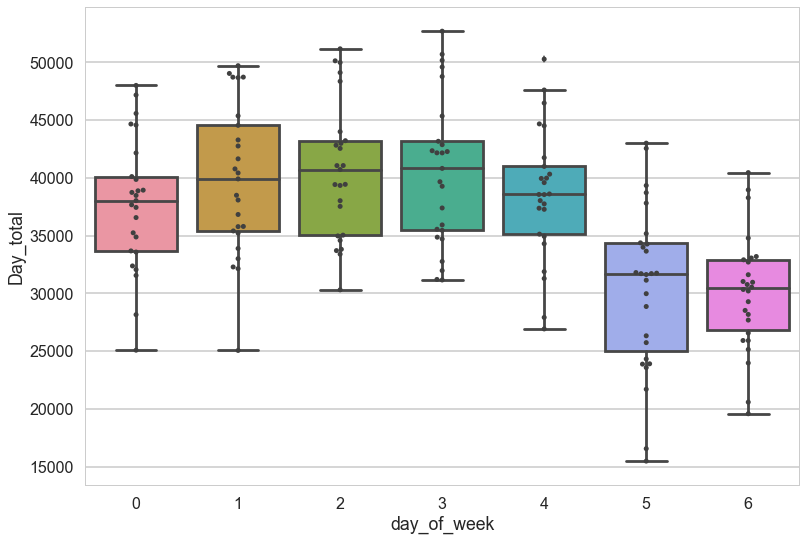

In [289]:
sns.set_context("poster")
sns.set_style("whitegrid")

ax = sns.boxplot(y="Day_total", x="day_of_week", data=all_data_out[all_data_out['season'] == 'summer'])
ax = sns.swarmplot(y="Day_total", x="day_of_week", data=all_data_out[all_data_out['season'] == 'summer'],color=".25" )

### Things to check for in addition to the above:  
Sample size big enough?  
Interactions?  

## 3) Make the regression model

First, try model with all data. Then try seperate model with the "summer" and "winter" data. 

In [331]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn import preprocessing


X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=1)

# Create model
model = sm.OLS(y_train, X_train)

# Fit model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Day_total   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     554.8
Date:                Mon, 14 Aug 2017   Prob (F-statistic):          2.65e-129
Time:                        17:12:20   Log-Likelihood:                -2551.1
No. Observations:                 244   AIC:                             5112.
Df Residuals:                     239   BIC:                             5130.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          3.485e+04   1616.991     21.550      0.000      3.17e+04   3.8e+04
x2          -2.36e+04   3762.494     -6.273      0.000      -3.1e+04 -1.62e+04
x3         -7.983e+05   1.06e+05     -7.511      0.000     -1.01e+06 -5.89e+05
x4          5.395e+04   9782.639      5.515      0.000      3.47e+04  7.32e+04
x5         -9.448e+04    1.3e+04     -7.242      0.000      -1.2e+05 -6.88e+04
==============================================================================
Omnibus:                        2.534   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                2.123
Skew:                          -0.108   Prob(JB):                        0.346
Kurtosis:                       2.597   Cond. No.                         192.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [354]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Fit the model to the train dataset
fit = lr.fit(X_train, y_train)

# Print out the R^2 for the model against the test dataset
print("Test:", lr.score(X_test,y_test))

Test: 0.610409493976


Of course, when building a predictive model it's best practice to use regularization and cross validation.  
Since we know we have some degree of collineraity we should try out ridge regression with cross-validation:

In [446]:
from sklearn.linear_model import RidgeCV

X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=2)


reg = RidgeCV(alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])

fit = reg.fit(X_train, y_train)


# Print out the R^2 for the model against the test dataset
print("Train:", reg.score(X_train,y_train))
print("Test:", reg.score(X_test,y_test))

print(reg.alpha_)


Train: 0.687328842791
Test: 0.60443866798
0.001


This model is OK, but not great. One thing we can check to investigate model performance is residuls.  I want to know if they are normally distributed, homoscedastic, and centered around zero.   
If I want to make a redidual scatterplot (including a trendline to see if the there is any trend with the values) with matplotlib I could use the code below:

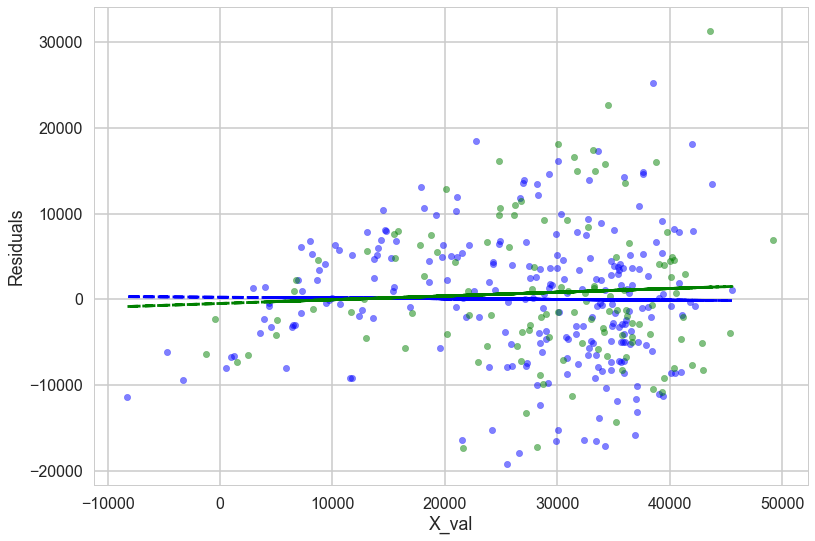

In [447]:
xtr = reg.predict(X_train)
ytr = reg.predict(X_train)-y_train
xte = reg.predict(X_test)
yte = reg.predict(X_test)-y_test
plt.scatter(xtr, ytr, c="b", s=40, alpha = 0.5)
plt.scatter(xte, yte, c="g", s=40, alpha = 0.5)
#plt.hlines(y=0, xmin = -1000, xmax = 45000)
# calc the trendline
ztr = np.polyfit(xtr, ytr, 1)
p = np.poly1d(ztr)
pylab.plot(x,p(x),"b--")
zte = np.polyfit(xte, yte, 1)
pe = np.poly1d(zte)
pylab.plot(x,pe(x),"g--")
plt.ylabel('Residuals')
plt.xlabel('X_val')

But it is easier with Seaborn:

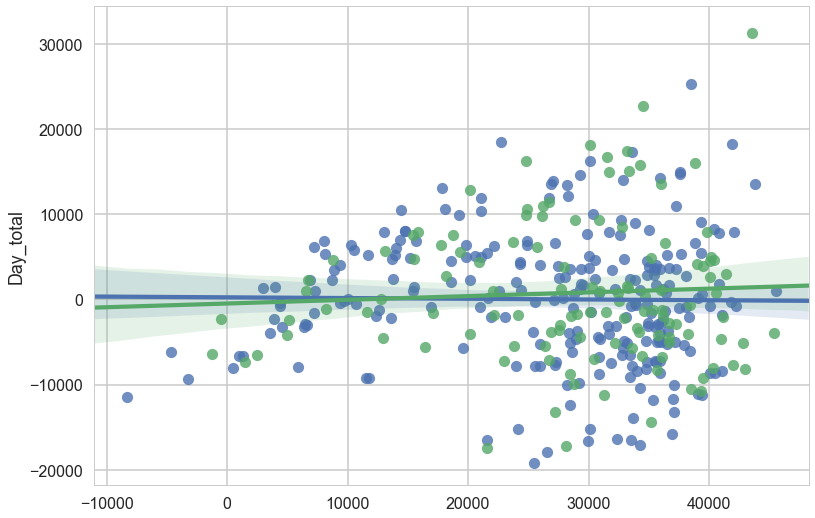

In [448]:
x = reg.predict(X_train)
y = reg.predict(X_train)-y_train

x1 = reg.predict(X_test)
y1 = reg.predict(X_test)-y_test

sns.regplot(x=x, y=y)
sns.regplot(x=x1, y=y1);


Histogram:

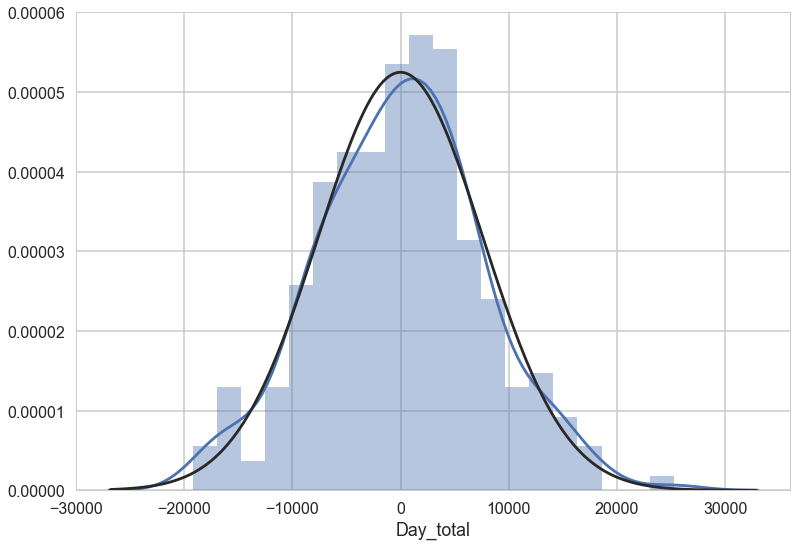

In [449]:
residuals = reg.predict(X_train)-y_train
sns.distplot(residuals, bins = 20,fit=stats.norm);


In this case we drop the 'temp_avg' as recommended by the VIF. We will also try lasso rather than ridge regression. 

In [575]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV


X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total', u'temp avg'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=2)

reg = LassoCV(alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])

fit = reg.fit(X_train, y_train)

# Print out the R^2 for the model against the test dataset
print("Train:", reg.score(X_train,y_train))
print("Test:", reg.score(X_test,y_test))

print(reg.alpha_)
print(reg.coef_)


Train: 0.679455492737
Test: 0.641481858849
1.0
[  65662.10280362 -123820.80753592   81376.29552175    8751.66561461]


In [574]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV


X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=2)

reg = LassoCV(alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])

fit = reg.fit(X_train, y_train)

# Print out the R^2 for the model against the test dataset
print("Train:", reg.score(X_train,y_train))
print("Test:", reg.score(X_test,y_test))

print(reg.alpha_)
print(reg.coef_)


Train: 0.687935027188
Test: 0.610409259152
0.0001
[-102999.93414023  -92780.74123128 -537901.06968648   24866.82844411
  -97308.36309353]


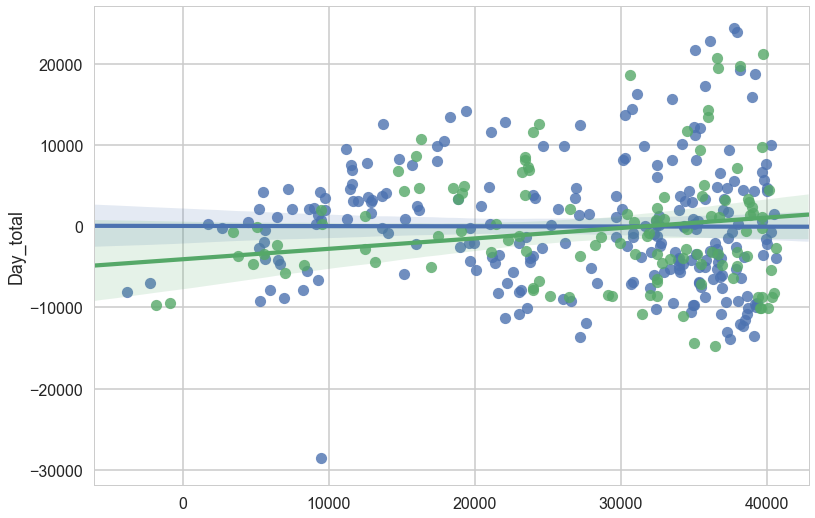

In [576]:
x = reg.predict(X_train)
y = reg.predict(X_train)-y_train

x1 = reg.predict(X_test)
y1 = reg.predict(X_test)-y_test

sns.regplot(x=x, y=y)
sns.regplot(x=x1, y=y1);


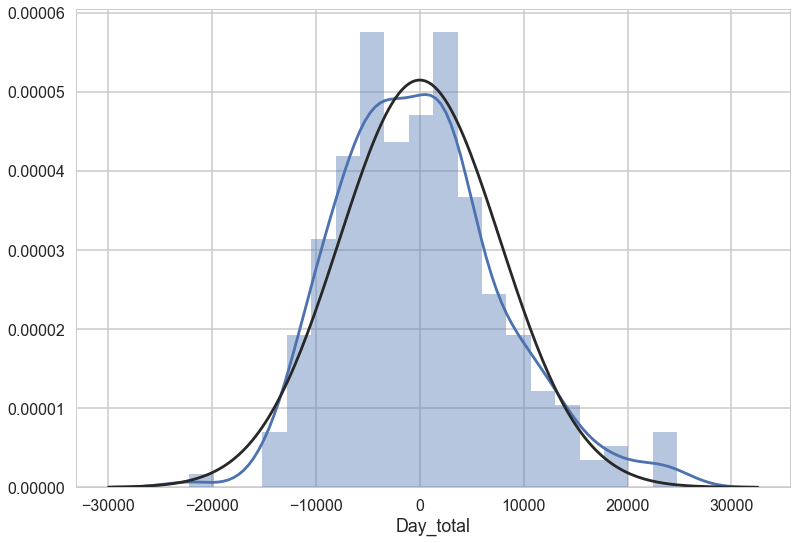

In [452]:
residuals = reg.predict(X_train)-y_train
sns.distplot(residuals, bins = 20, fit=stats.norm);


Try fitting the data that is divided into winter and summer:

In [453]:
X = all_data[all_data['season']=='summer'].drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total'], axis =1)
y = all_data[all_data['season']=='summer']['Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=6)

reg = RidgeCV(alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])

fit = reg.fit(X_train, y_train)


# Print out the R^2 for the model against the test dataset
print("Train:", reg.score(X_train,y_train))
print("Test:", reg.score(X_test,y_test))

print(reg.alpha_)

Train: 0.54903916275
Test: 0.55166507894
0.0005


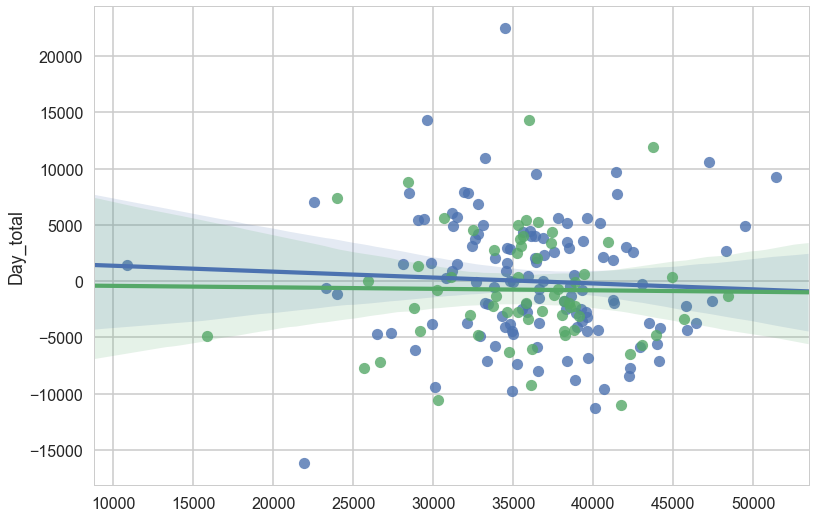

In [454]:
x = reg.predict(X_train)
y = reg.predict(X_train)-y_train

x1 = reg.predict(X_test)
y1 = reg.predict(X_test)-y_test

sns.regplot(x=x, y=y)
sns.regplot(x=x1, y=y1);


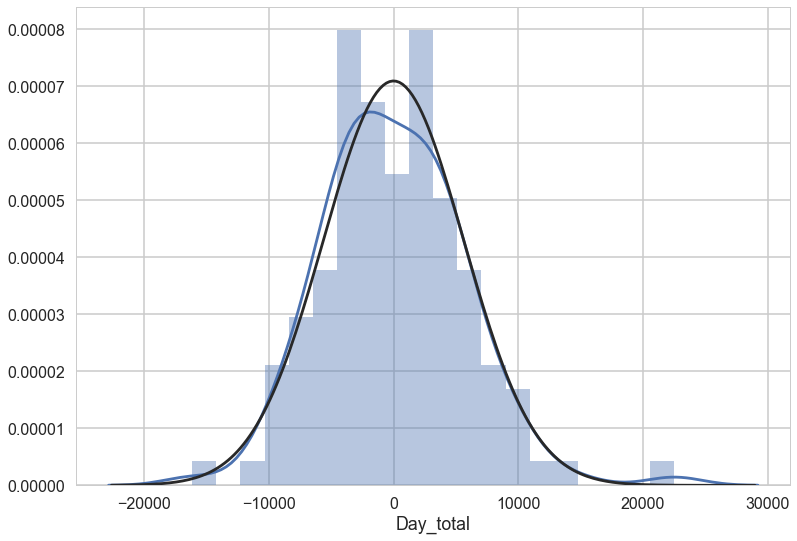

In [455]:
residuals = reg.predict(X_train)-y_train
sns.distplot(residuals, bins = 20,fit=stats.norm);


In [456]:
X = all_data[all_data['season']=='winter'].drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total'], axis =1)
y = all_data[all_data['season']=='winter']['sqrt_Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=6)

reg = RidgeCV(alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])

fit = reg.fit(X_train, y_train)


# Print out the R^2 for the model against the test dataset
print("Train:", reg.score(X_train,y_train))
print("Test:", reg.score(X_test,y_test))

print(reg.alpha_)

Train: 0.689648353454
Test: 0.74956945491
0.0005


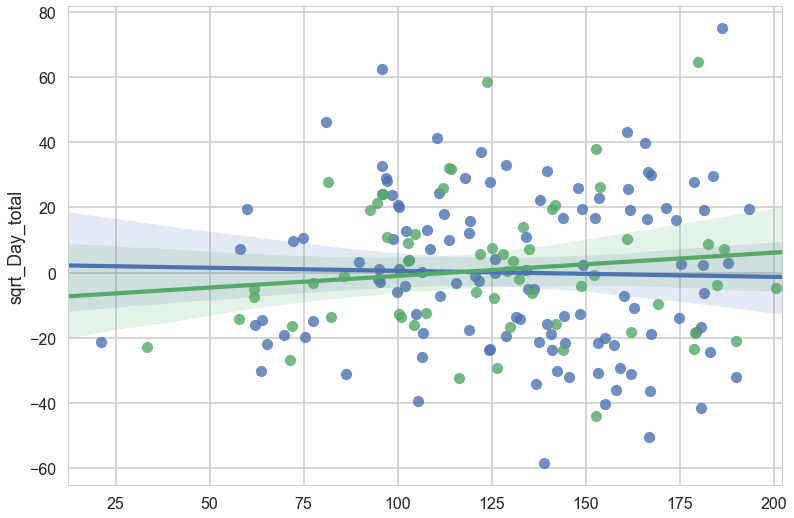

In [457]:
x = reg.predict(X_train)
y = reg.predict(X_train)-y_train

x1 = reg.predict(X_test)
y1 = reg.predict(X_test)-y_test

sns.regplot(x=x, y=y)
sns.regplot(x=x1, y=y1);


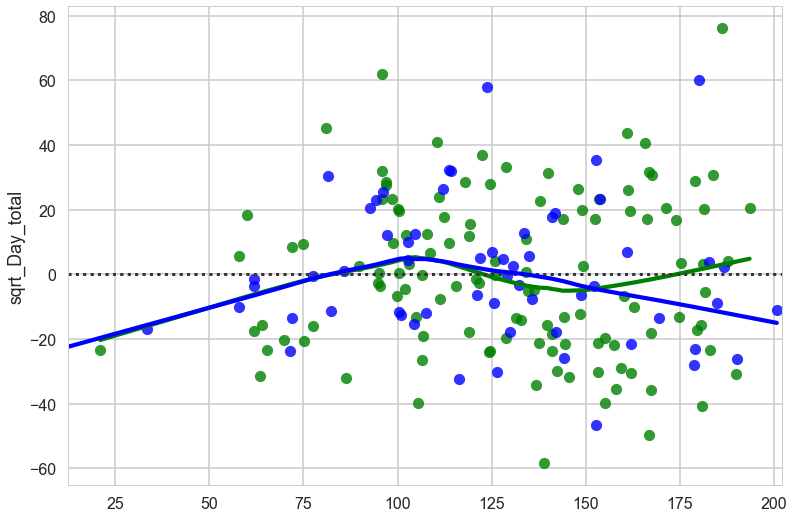

In [462]:
sns.residplot(x, y, lowess=True, color="g")
sns.residplot(x1, y1, lowess=True, color="b")

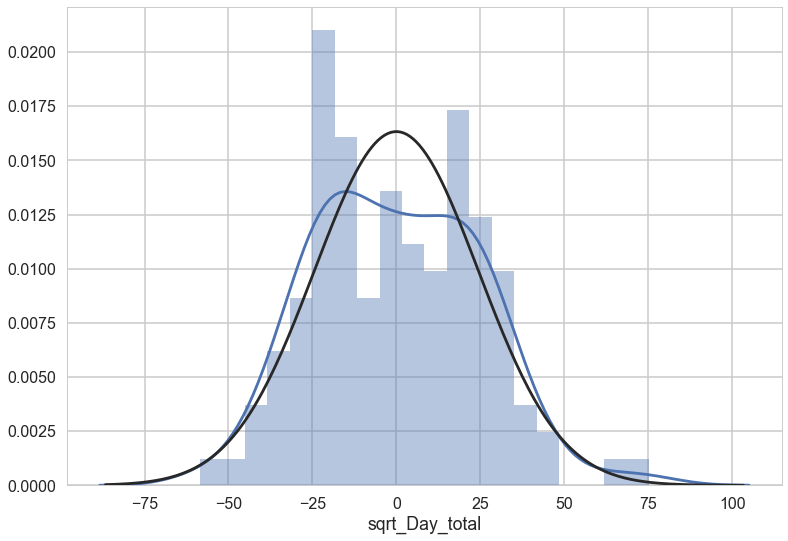

In [458]:
residuals = reg.predict(X_train)-y_train
sns.distplot(residuals, bins = 20,fit=stats.norm);


What next? 
Try tests for heteroskedacity: https://datascienceplus.com/how-to-detect-heteroscedasticity-and-rectify-it/

https://www.r-bloggers.com/how-to-detect-heteroscedasticity-and-rectify-it/

https://stats.stackexchange.com/questions/68710/heteroskedasticity-residual-plot-interpretation

What about non-linear features?
Read the regression chapter in think stats
Also read some info about heteroskadicity.


While the above model appear to have fairly normal and non-heteroskedastic residuals, the fits are not that awesome (0.5-0.7). I'm going to see if I can get better fits by introducing nonlinear terms and interactions. 

This can be done using sklearn:

Train: 0.838463949517
Test: 0.763751730101
5e-06
[  0.00000000e+00   3.16614509e+05   7.47650697e+05   5.48806925e+05
  -2.36182092e+05   1.48319800e+06  -2.06422878e+05   7.55513350e+05
  -4.63439679e+03  -1.98237778e+05   7.65161187e+05  -8.39023849e+05
  -2.37354431e+05  -5.95124392e+04  -7.04954872e+05   2.90642792e+06
  -6.05971458e+05   7.19329675e+05  -4.15561207e+05   5.61182800e+05
  -1.44541999e+06  -3.80820762e+05  -2.32293915e+05  -4.10043504e+05
   1.36911462e+05  -4.27765379e+05  -2.97642536e+05  -6.83626239e+05
  -2.46666842e+05   1.47848581e+03   2.79054027e+06  -7.55864079e+05
   6.47857974e+05  -8.55814098e+05  -4.99743654e+05  -9.39648369e+05
  -6.57220991e+05   8.61339722e+05  -5.48176609e+03  -8.41917820e+05
   5.57798036e+05   4.78751370e+05   1.29331061e+05   1.22129094e+06
  -6.91897239e+05  -1.41923370e+05   1.09035692e+05   3.32987353e+05
   1.62072317e+05  -2.89834394e+05  -3.18217008e+04   2.78309408e+05
  -7.83253512e+05   1.42558580e+06   8.26543720e+04   

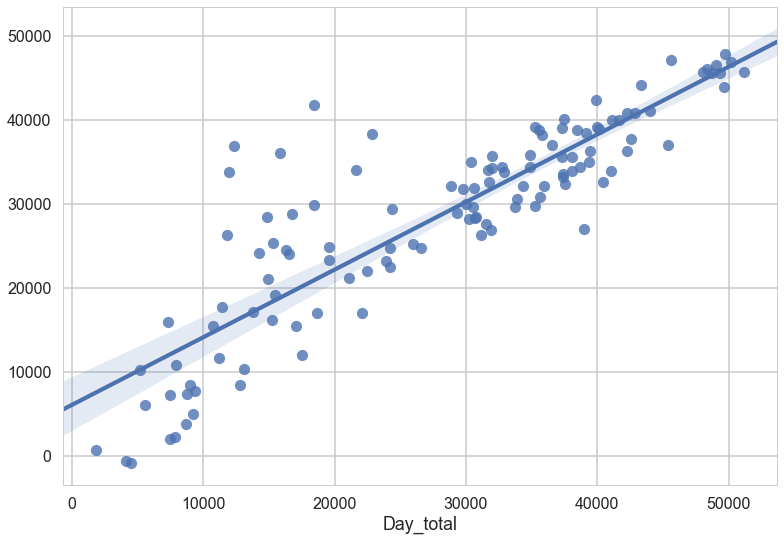

In [577]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=2)


reg = RidgeCV(alphas=[0.0000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])
model = make_pipeline(PolynomialFeatures(4), reg)
fit = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.regplot(x=y_test, y=y_pred)
#            label="2")


# Print out the R^2 for the model against the test dataset
print("Train:", model.score(X_train,y_train))
print("Test:", model.score(X_test,y_test))

print(reg.alpha_)
print(reg.coef_)

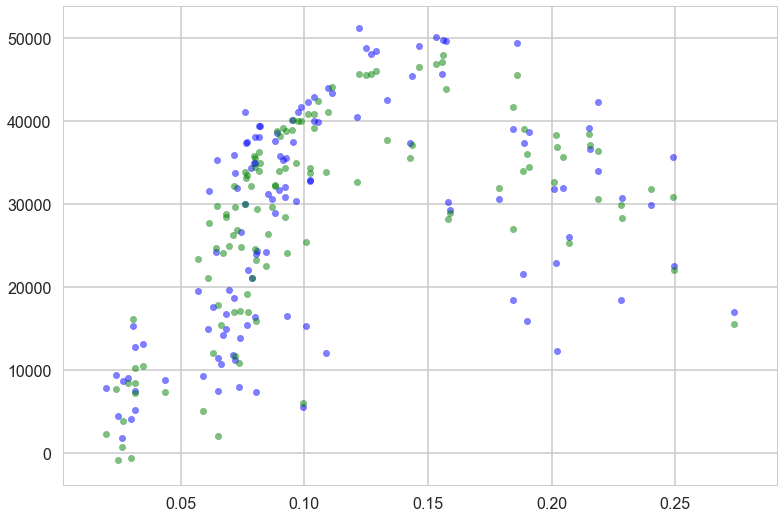

In [578]:
var =3
plt.scatter(X_test[:,var], y_test, c="b", s=40, alpha = 0.5)
plt.scatter(X_test[:,var], y_pred, c="g", s=40, alpha = 0.5)

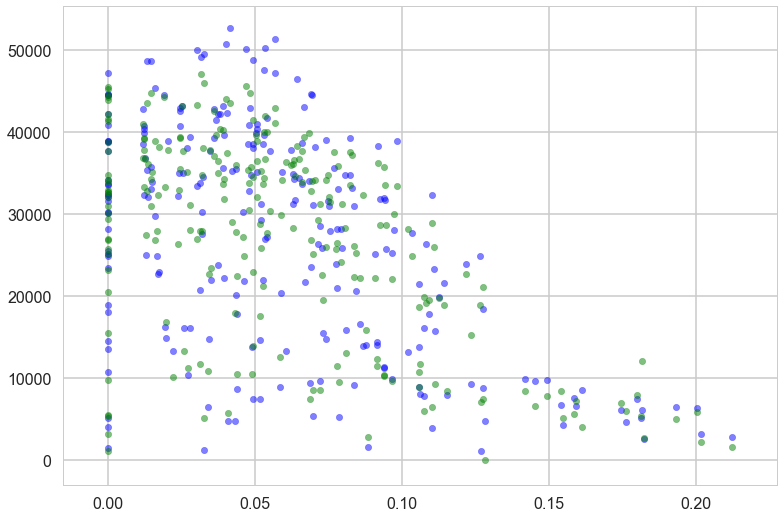

In [579]:
var = 4
plt.scatter(X_train[:,var], y_train, c="b", s=40, alpha = 0.5)
plt.scatter(X_train[:,var], model.predict(X_train), c="g", s=40, alpha = 0.5)

/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Train: 0.836881538592
Test: 0.765031907286
0.05
[  0.00000000e+00   1.71355393e+05   3.97722845e+03  -0.00000000e+00
   2.34728385e+05   2.03409192e+04   1.18379884e+04   2.24623185e+04
  -0.00000000e+00   2.64794549e+04  -5.24953584e+03  -9.58405793e+02
  -0.00000000e+00  -1.41422569e+05  -1.70324477e+04   1.73641690e+07
  -1.63226001e+06   1.20357555e+06  -3.47446536e+05  -0.00000000e+00
  -6.55068401e+05   1.19924781e+03   5.49952275e+03  -5.46391014e+05
   1.39564175e+05   1.70559284e+04   7.33459033e+03  -0.00000000e+00
  -2.93256451e+05   7.77126663e+04   0.00000000e+00  -4.67298476e+05
   0.00000000e+00  -3.77009073e+05  -0.00000000e+00  -3.83544633e+05
   1.01300450e+05   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00   1.82601554e+06
  -0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00  -0.00000000e+00  -0.00000000e+00   0.00000000e+00
  -1.07493024e+06   2.53515746e+06  -0.00000000e+00   6

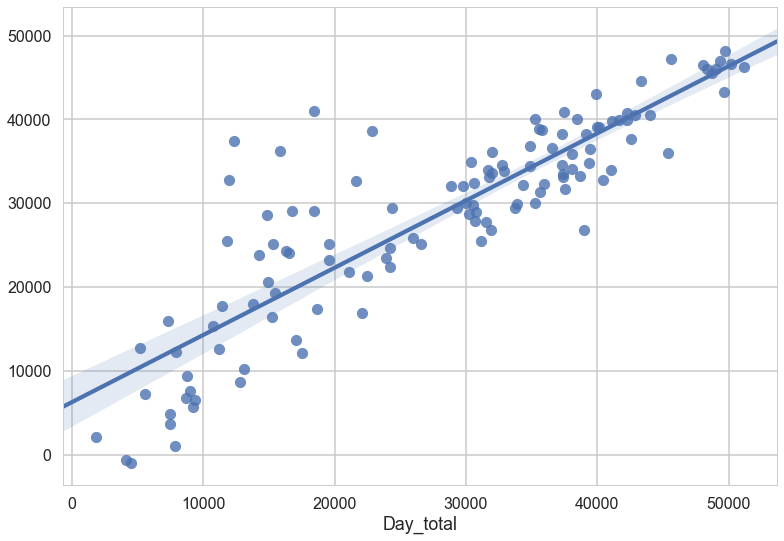

In [580]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=2)


reg = LassoCV(alphas=[0.0000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])
model = make_pipeline(PolynomialFeatures(4), reg)
fit = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.regplot(x=y_test, y=y_pred)
#            label="2")


# Print out the R^2 for the model against the test dataset
print("Train:", model.score(X_train,y_train))
print("Test:", model.score(X_test,y_test))

print(reg.alpha_)
print(reg.coef_)

This is better! What about interaction terms? 

Train: 0.790172520734
Test: 0.72374027053
5e-06


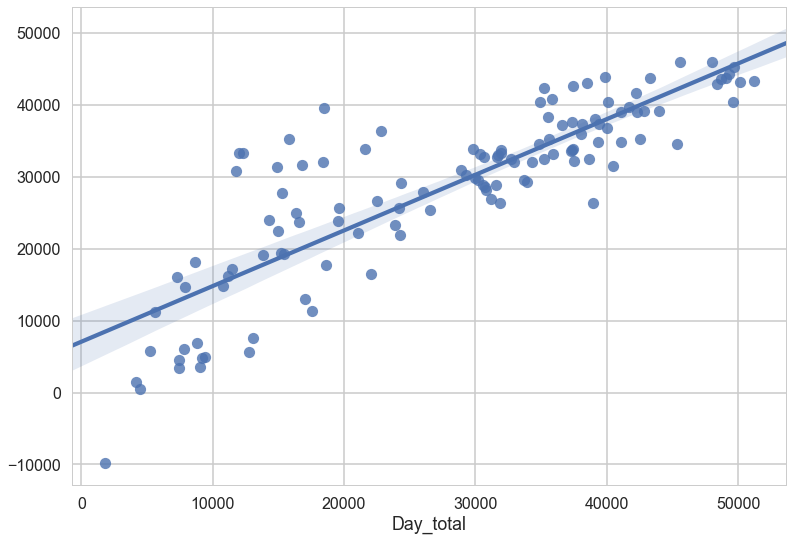

In [555]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=2)


reg = RidgeCV(alphas=[0.0000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])
model = make_pipeline(PolynomialFeatures(degree = 10,interaction_only=True ), reg)
fit = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.regplot(x=y_test, y=y_pred)
#            label="2")


# Print out the R^2 for the model against the test dataset
print("Train:", model.score(X_train,y_train))
print("Test:", model.score(X_test,y_test))

print(reg.alpha_)


Model: OLS MSE: 54098093.7907
Train: 0.735675048832
Test: 0.701859602649


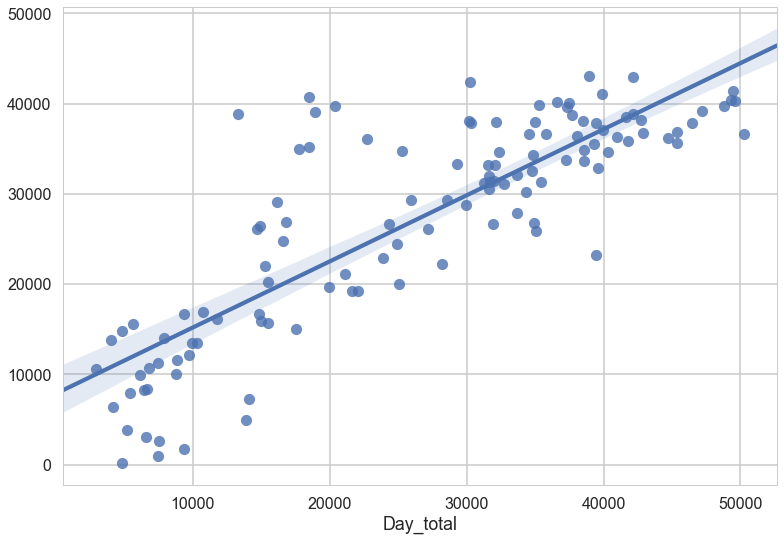

Model: HuberRegressor MSE: 64067223.1333
Train: 0.63078255169
Test: 0.64691866157


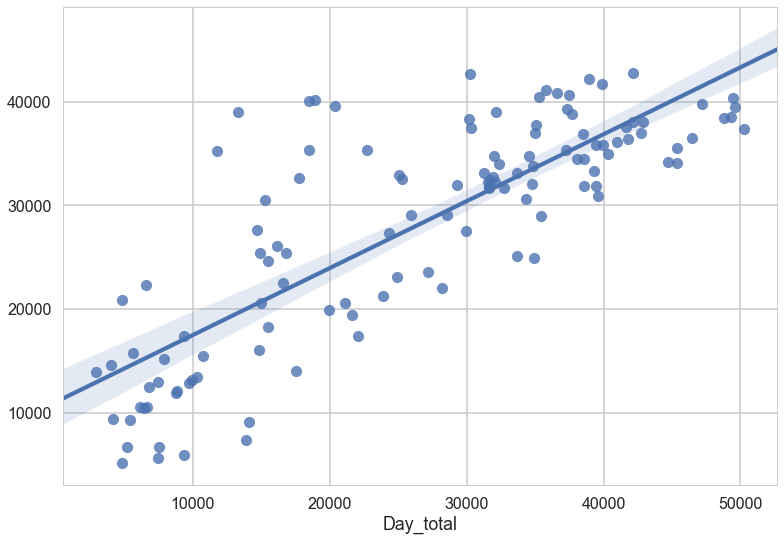

Model: LassoCV MSE: 57311783.4874
Train: 0.663263043503
Test: 0.684148614036


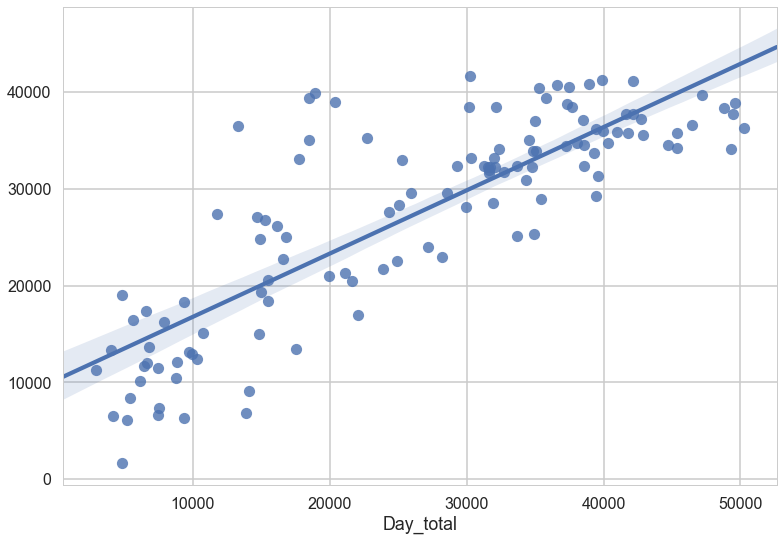

Model: RidgeCV MSE: 54289786.9985
Train: 0.734392866956
Test: 0.700803160821


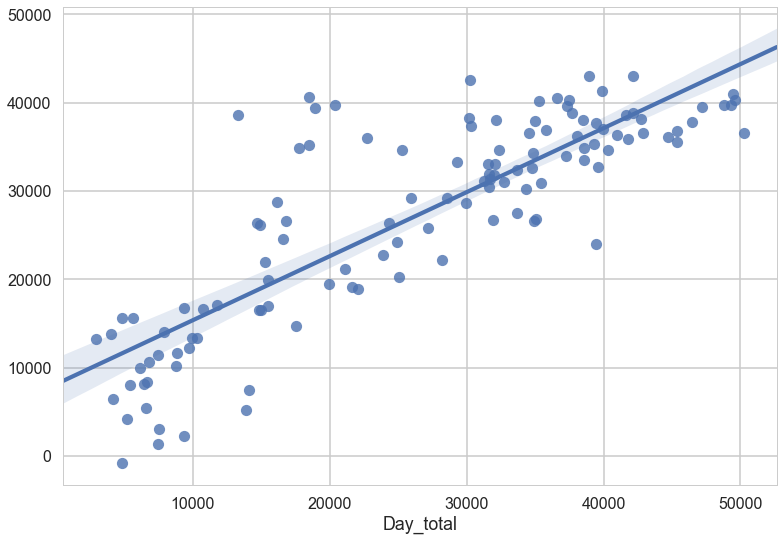

,Feature_Names,OLS,HuberRegressor,LassoCV,RidgeCV
0,1,0.000000e+00,-4.093220,0.000000,0.000000e+00
1,avg wind,2.881426e+05,6445.019343,-0.000000,2.325658e+05
2,Precip(in),2.036391e+07,-13111.996124,-91701.873053,1.627868e+07
3,month,3.102596e+05,27291.189129,13810.792317,2.541786e+05
4,day_of_week,3.415728e+05,-8381.042495,-5519.650598,2.637450e+05
5,avg wind Precip(in),-2.018282e+07,-10892.950578,-0.000000,-1.615173e+07
6,avg wind month,-1.878382e+05,35775.663889,54202.384483,-1.423960e+05
7,avg wind day_of_week,-3.218074e+05,-2112.123833,-0.000000,-2.496341e+05
8,Precip(in) month,-2.185454e+07,-6028.353773,-3478.626295,-1.772367e+07
9,Precip(in) day_of_week,-2.329772e+07,-1472.627708,0.000000,-1.841057e+07


In [619]:
from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total', u'temp avg'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)

X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=3)
estimators = [('OLS', LinearRegression()),
              ('HuberRegressor', HuberRegressor()),
              ('LassoCV',LassoCV(alphas=[0.0000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])),
              ('RidgeCV', RidgeCV(alphas=[0.0000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0]))]

name = PolynomialFeatures(4, interaction_only=True).fit(X_train)
features = name.get_feature_names(X.columns)

df_coeff = pd.DataFrame()
df_coeff['Feature_Names'] = features

for name, estimator in estimators:

  
        model = make_pipeline(PolynomialFeatures(4, interaction_only=True), estimator)
        model.fit(X_train, y_train)
        #estimator.fit(X_train, y_train)
        mse = mean_squared_error(model.predict(X_test), y_test)
        
        print("Model:", name, "MSE:", mse)
        print("Train:", model.score(X_train,y_train))
        print("Test:", model.score(X_test,y_test))
        
        #print(model.alpha_)
        #print(estimator.coef_)
        y_plot = model.predict(X_test)
        #plt.plot(y_plot, y_test, label='%s: error = %.3f' % (name, mse))
        sns.regplot(x=y_test, y=y_plot)
        plt.show()
        df_coeff[name] = estimator.coef_
        
df_coeff

Model: OLS MSE: 8.61919757938e+14
Train: 0.890889469689
Test: -4750131.23405


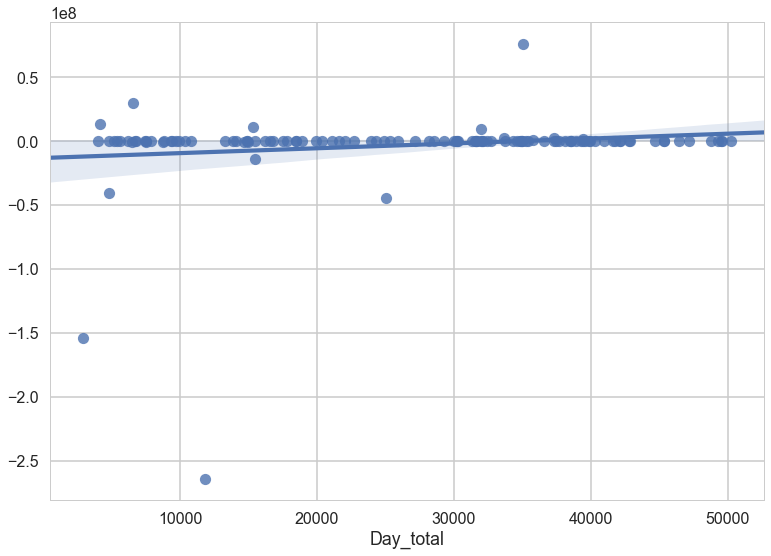

Model: HuberRegressor MSE: 61994423.4607
Train: 0.64800139793
Test: 0.658342082891


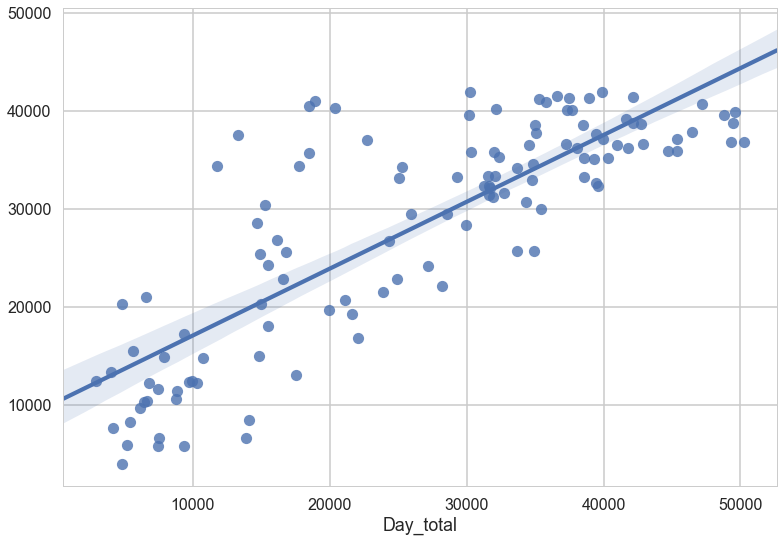

Model: LassoCV MSE: 57461869.6756
Train: 0.667501408366
Test: 0.683321472955


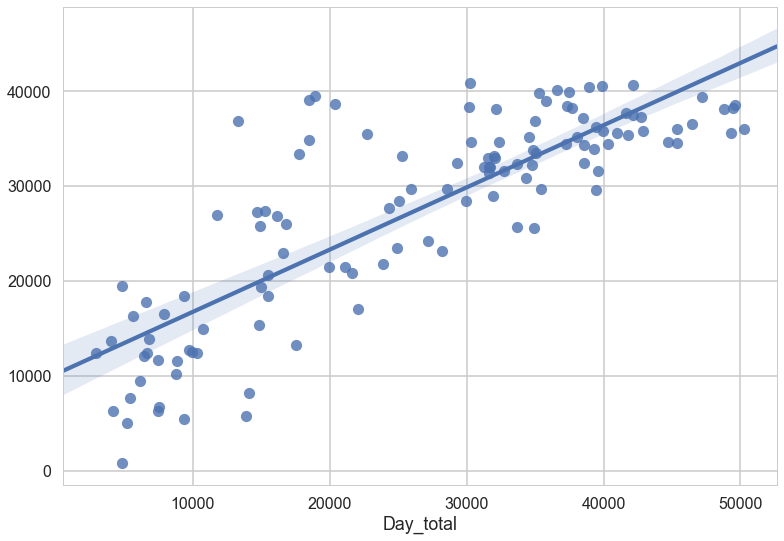

Model: RidgeCV MSE: 52614553.2529
Train: 0.76157883385
Test: 0.710035553675


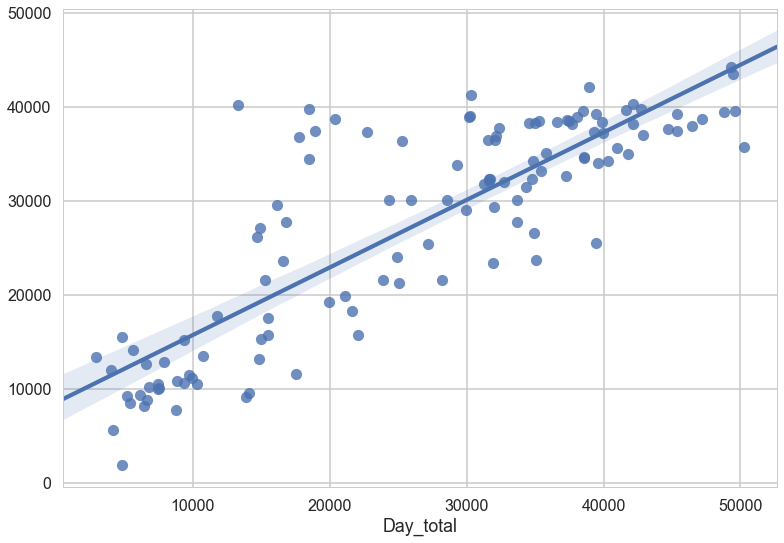

,Feature_Names,OLS,HuberRegressor,LassoCV,RidgeCV
0,1,2.827008e+13,-2.538700,0.000000,0.000000
1,avg wind,4.889172e+17,1342.835763,-0.000000,25808.122970
2,Precip(in),1.851494e+17,-11880.475357,-95474.167611,-71226.226019
3,month,1.891140e+17,9822.014419,2312.542175,-84802.598511
4,day_of_week,1.012011e+17,-3194.073503,-0.000000,-51551.970291
5,avg wind^2,-1.581506e+17,65.454454,-0.000000,-61086.490224
6,avg wind Precip(in),-4.788648e+16,-9786.444685,-0.000000,1976.633833
7,avg wind month,-4.577693e+15,10671.182036,64740.521486,-31093.327569
8,avg wind day_of_week,-1.855894e+16,-424.818425,-0.000000,20840.305555
9,Precip(in)^2,-1.839679e+17,-307.302576,0.000000,311161.458548


In [624]:
from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total', u'temp avg'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)

X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=3)
estimators = [('OLS', LinearRegression()),
              ('HuberRegressor', HuberRegressor()),
              ('LassoCV',LassoCV(alphas=[0.0000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])),
              ('RidgeCV', RidgeCV(alphas=[0.0000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0]))]

name = PolynomialFeatures(6, interaction_only=False).fit(X_train)
features = name.get_feature_names(X.columns)

df_coeff = pd.DataFrame()
df_coeff['Feature_Names'] = features

for name, estimator in estimators:

  
        model = make_pipeline(PolynomialFeatures(6, interaction_only=False), estimator)
        model.fit(X_train, y_train)
        #estimator.fit(X_train, y_train)
        mse = mean_squared_error(model.predict(X_test), y_test)
        
        print("Model:", name, "MSE:", mse)
        print("Train:", model.score(X_train,y_train))
        print("Test:", model.score(X_test,y_test))
        
        #print(model.alpha_)
        #print(estimator.coef_)
        y_plot = model.predict(X_test)
        #plt.plot(y_plot, y_test, label='%s: error = %.3f' % (name, mse))
        sns.regplot(x=y_test, y=y_plot)
        plt.show()
        df_coeff[name] = estimator.coef_
        
df_coeff

In [635]:
from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline




def regression_check(X, y, polynomial_degree, interaction):
    normalized_X = preprocessing.normalize(X)
    X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=3)
    estimators = [('OLS', LinearRegression()),
                  ('HuberRegressor', HuberRegressor()),
                  ('LassoCV',LassoCV(alphas=[0.0000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0])),
                  ('RidgeCV', RidgeCV(alphas=[0.0000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0]))]

    name = PolynomialFeatures(polynomial_degree, interaction_only=interaction).fit(X_train)
    features = name.get_feature_names(X.columns)

    df_coeff = pd.DataFrame()
    df_coeff['Feature_Names'] = features

    
    for name, estimator in estimators:
            
            #Tomorrow, make a dict/list where can add errors for each type so can make a table at each 
            #polynomial value. I can use this to compare models

            model = make_pipeline(PolynomialFeatures(polynomial_degree, interaction_only=interaction), estimator)
            model.fit(X_train, y_train)
            #estimator.fit(X_train, y_train)
            mse = mean_squared_error(model.predict(X_test), y_test)

            print("Model:", name, "MSE:", mse)
            print("Train:", model.score(X_train,y_train))
            print("Test:", model.score(X_test,y_test))

            #print(model.alpha_)
            #print(estimator.coef_)
            y_plot = model.predict(X_test)
            #plt.plot(y_plot, y_test, label='%s: error = %.3f' % (name, mse))
            #sns.regplot(x=y_test, y=y_plot)
            #plt.show()
            df_coeff[name] = estimator.coef_

    print(df_coeff)
    
    
X = all_data.drop(['Day_total', u'season',  u'log_Day_total', u'sqrt_Day_total', u'temp avg'], axis =1)
y = all_data['Day_total']

for polynomial_degree in range(4,5):
    print("Degree:", polynomial_degree)
    regression_check(X, y, polynomial_degree, False)

Degree: 4
Model: OLS MSE: 140018305.826
Train: 0.765613183818
Test: 0.228344098464
Model: HuberRegressor MSE: 62827612.0568
Train: 0.641841037065
Test: 0.653750291172
Model: LassoCV MSE: 57264539.2663
Train: 0.664171554663
Test: 0.684408982006
Model: RidgeCV MSE: 51740301.5694
Train: 0.750304041717
Test: 0.714853648474
                            Feature_Names           OLS  HuberRegressor  \
0                                       1  5.645646e+17        5.462967   
1                                avg wind -1.534414e+17     1719.644769   
2                              Precip(in) -1.163188e+16   -12098.170004   
3                                   month -1.971418e+16    13380.484211   
4                             day_of_week  4.769336e+16    -3823.638804   
5                              avg wind^2 -5.952523e+16      -29.464404   
6                     avg wind Precip(in)  3.431491e+15   -10033.508853   
7                          avg wind month  2.221834e+16    15396.100798   
8   

## Question 6
• Using the tool of your preference, develop a visualization that displays something interesting about the data.

I'd like to show a map with the stations that have the highest number of bikes removed and the stations with the highest number of bikes added so I can visualize where people are starting their bike trips and ending them. 